# Data Augmentation
- Demonstrates how to apply data augmentation which is a technique to increase the diversity of training set by applying random transformations.
- Full tutorial reference: https://www.tensorflow.org/tutorials/images/data_augmentation

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.3


## Download a Dataset from TensorFlow Dataset
Another way to download a dataset is from TensorFlow Dataset. Here, we download ```tf_flowers``` dataset which is identical to the flower images dataset used in the previous tutorials.

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    try_gcs=True
)

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


## Use Keras Preprocessing Layers

```tf.keras.layers.Resizing``` and ```tf.keras.layers.Rescaling``` for image resizing and pixel values rescaling task.

In [4]:
img_size = 180

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),
    tf.keras.layers.Rescaling(1./255)
])

In [5]:
get_label_name = metadata.features['label'].int2str

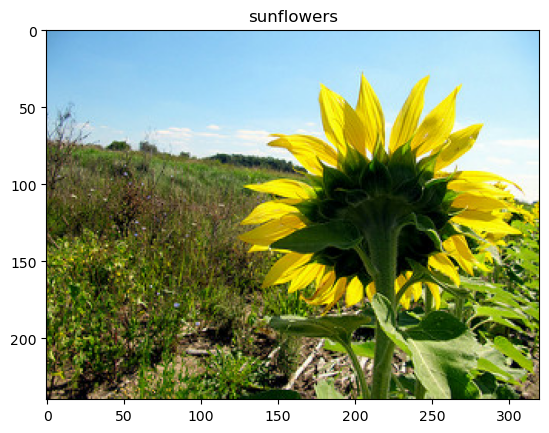

In [6]:
from itertools import islice
image, label = next(islice(iter(train_ds), 2, None))
plt.figure()
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

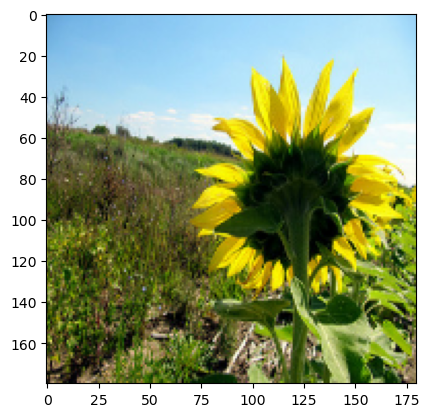

Min and max pixel values: 0.0 1.0


In [7]:
result = resize_and_rescale(image)
plt.figure()
plt.imshow(result)
plt.show()

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

```tf.keras.layers.RandomFlip```, ```tf.keras.layers.RandomRotation``` and ```tf.keras.layers.RandomCrop``` etc. preprocessing layers are used to perform data augmentation.

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2)
])

In [9]:
result = tf.cast(tf.expand_dims(result, 0), tf.float32)

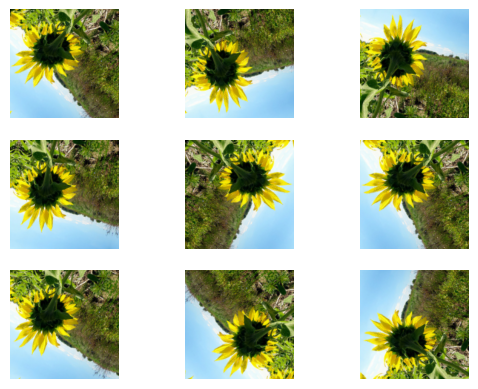

In [10]:
plt.figure()
for i in range(9):
    augmented_img = data_augmentation(result)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_img[0])
    plt.axis('off')

plt.show()

## Apply the Preprocessing Layers to the Datasets
Configure and preprocess the training, validation and test datasets with the Keras preprocessing layers. Resize and rescale the dataset using ```Dataset.map```. Remember that data augmentation should only be applied to the training dataset. Lastly, as what we always do, use buffered prefetching on all datasets to yield data from disk.

In [11]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
def preprocess(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
train_ds = preprocess(train_ds, shuffle=True, augment=True)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

## Train the Model
Simple CNN model using ```tf.keras.optimizers.Adam``` optimizer and ```tf.keras.losses.SparseCategoricalCrossentropy``` loss function.

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
92/92 [==============================] - 73s 745ms/step - loss: 1.4458 - accuracy: 0.3542 - val_loss: 1.2721 - val_accuracy: 0.4605
Epoch 2/5
92/92 [==============================] - 70s 744ms/step - loss: 1.1487 - accuracy: 0.5293 - val_loss: 1.1277 - val_accuracy: 0.5695
Epoch 3/5
92/92 [==============================] - 69s 734ms/step - loss: 1.0491 - accuracy: 0.5783 - val_loss: 1.0917 - val_accuracy: 0.5804
Epoch 4/5
92/92 [==============================] - 68s 723ms/step - loss: 0.9841 - accuracy: 0.6148 - val_loss: 1.2038 - val_accuracy: 0.5286
Epoch 5/5
92/92 [==============================] - 66s 699ms/step - loss: 0.9356 - accuracy: 0.6400 - val_loss: 1.0289 - val_accuracy: 0.5995


In [18]:
model_eval = model.evaluate(test_ds)
print('Accuracy:', model_eval[1])

12/12 [==============================] - 3s 181ms/step - loss: 0.9915 - accuracy: 0.5777
Accuracy: 0.5776566863059998


## Using ```tf.data``` and ```tf.image```
For finer control, it is possible to write self-designed data augmentation pipelines or layers using ```tf.data``` and ```tf.image```.

In [19]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    try_gcs=True
)

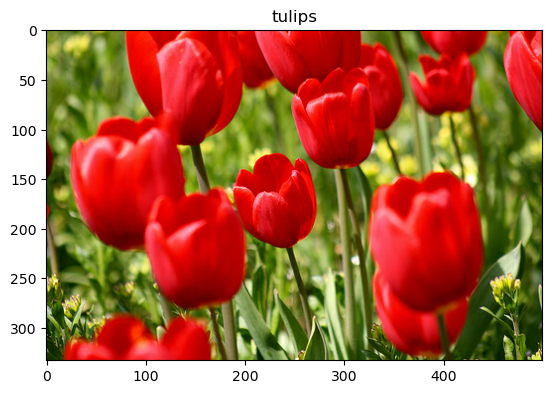

In [20]:
image, label = next(iter(train_ds))
plt.figure()
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

In [21]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')

Flip an image either vertically or horizontally with ```tf.image.flip_left_right```.

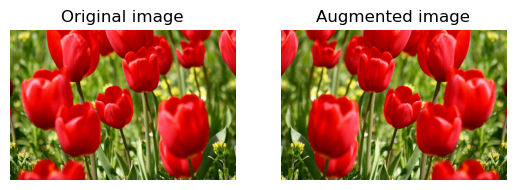

In [22]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Grayscale an image with ```tf.image.rgb_to_grayscale```.

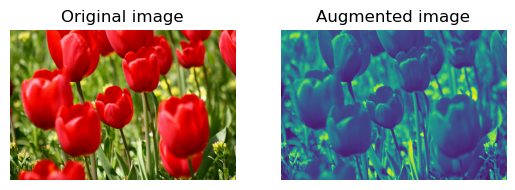

In [23]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))

Saturate an image with ```tf.image.adjust_saturation```.

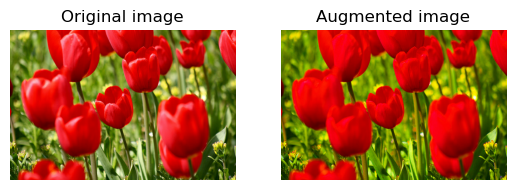

In [24]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

Change the brightness of image with ```tf.image.adjust_brightness```.

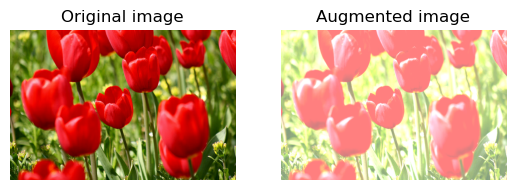

In [25]:
bright = tf.image.adjust_brightness(image, 0.5)
visualize(image, bright)

Crop an image from centre up to the desired part with ```tf.image.central_crop```.

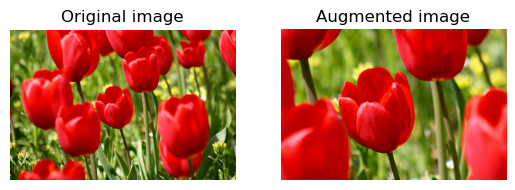

In [26]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

Rotate an image by 90 degrees with ```tf.image.rot90```.

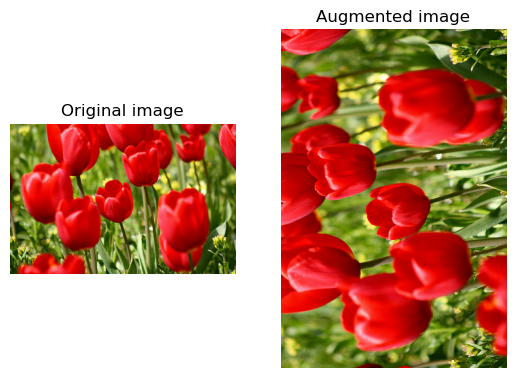

In [27]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

## Random Transformations
Applying random transformations to the images can further help generalize and expand the dataset. There are eight random image transformation operations as follows:
1. ```tf.image.stateless_random_brightness```
2. ```tf.image.stateless_random_contrast```
3. ```tf.image.stateless_random_crop```
4. ```tf.image.stateless_random_flip_left_right```
5. ```tf.image.stateless_random_flip_up_down```
6. ```tf.image.stateless_random_hue```
7. ```tf.image.stateless_random_jpeg_quality```
8. ```tf.image.stateless_random_saturation```

In [28]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
    try_gcs=True
)

Define ```resize_and_rescale``` function for resizing and rescaling the images and its pixel values.

In [29]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_size, img_size])
    image = (image / 255.0)
    return image, label

Also, define ```augment``` function for applying the random transformations to the images using the eight mentioned operations. 

In [30]:
def augment(data, seed):
    image, label = data
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, img_size+6, img_size+6)
    # random number generator for seed
    # seed is a tensor of shape (2,) where same seed returns the same result independent of how many times it is executed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # random crop 
    image = tf.image.stateless_random_crop(image, size=[img_size, img_size, 3], seed=seed)
    # random brightness
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image, label

Create a ```tf.random.Generator``` object with an initial seed. Then calling the ```make_seeds``` function to generate a new, unique seed value for random transformation.

In [31]:
random_number_generator = tf.random.Generator.from_seed(123, alg='philox')

In [32]:
def update_seeds(x, y):
    seed = random_number_generator.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [34]:
train_ds = (train_ds.shuffle(1000).map(update_seeds, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE))
val_ds = (val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE))
test_ds = (test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(buffer_size=AUTOTUNE))

Train 5 more epochs.

In [37]:
model.fit(train_ds, validation_data=val_ds, initial_epoch=5, epochs=10)

Epoch 6/10
92/92 [==============================] - 61s 654ms/step - loss: 1.0659 - accuracy: 0.5790 - val_loss: 0.9122 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 65s 706ms/step - loss: 0.9487 - accuracy: 0.6298 - val_loss: 0.9599 - val_accuracy: 0.6594
Epoch 8/10
92/92 [==============================] - 66s 719ms/step - loss: 0.8713 - accuracy: 0.6649 - val_loss: 0.9339 - val_accuracy: 0.6703
Epoch 9/10
92/92 [==============================] - 66s 722ms/step - loss: 0.7611 - accuracy: 0.7153 - val_loss: 0.8845 - val_accuracy: 0.6703
Epoch 10/10
92/92 [==============================] - 66s 719ms/step - loss: 0.6684 - accuracy: 0.7527 - val_loss: 0.9826 - val_accuracy: 0.6676


In [38]:
model_eval = model.evaluate(test_ds)
print('Accuracy:', model_eval[1])

12/12 [==============================] - 3s 188ms/step - loss: 0.8904 - accuracy: 0.6839
Accuracy: 0.6839237213134766
